In [1]:
%load_ext autoreload
%autoreload 2

# Simple representation space tests with an FCN


## Imports

In [2]:
from typing import Optional, List, Callable, Dict, Any, Tuple, Union
from functools import partial
import logging
import os
import ast
import json

import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import equinox as eqx
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import wandb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')

from synbio_morpher.utils.misc.numerical import make_symmetrical_matrix_from_sequence
from synbio_morpher.utils.misc.string_handling import convert_liststr_to_list
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.results.analytics.naming import get_true_names_analytics, get_true_interaction_cols

jax.devices()

I0000 00:00:1696008888.035544  569033 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[CpuDevice(id=0)]

## Load data

In [3]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
data.drop(columns=['Unnamed: 0'], inplace=True)
for c in get_true_interaction_cols(data, interaction_attr='binding_sites_idxs', remove_symmetrical=True) + get_true_interaction_cols(
        data, interaction_attr='binding_site_group_range', remove_symmetrical=True):
    data[c] = data[c].map(ast.literal_eval)

## Model: network of fully connected layers

In [4]:
# https://coderzcolumn.com/tutorials/artificial-intelligence/haiku-cnn

class FCN(hk.Module):

    def __init__(self, layer_sizes: List[int], n_head: int):
        super().__init__(name="FCN")
        self.layers = self.create_layers(layer_sizes, n_head)
        
        
    def create_layers(self, layer_sizes: List[int], n_head: int):
        sizes = layer_sizes + [n_head]
        l = []
        for i, s in enumerate(sizes):
            if l:
                l.append(jax.nn.relu)
                if np.mod(i, 2) == 0:
                    l.append(jax.nn.sigmoid)
            # if sj == n_head:
            #     l.append(eqx.nn.Dropout(p=0.4))
            
            # He initialisation
            l.append(
                hk.Linear(s, w_init=hk.initializers.VarianceScaling(scale=2.0))
            )
        l.append(jax.nn.log_softmax)
        return l
        

    def __call__(self, x: Float[Array, " num_interactions"], inference: bool = False, seed: int = 0) -> Float[Array, " n_head"]:
        for i, layer in enumerate(self.layers):
            kwargs = {} if not type(layer) == eqx.nn.Dropout else {
                'inference': inference, 'key': jax.random.PRNGKey(seed)}

            x = layer(x, **kwargs)
            
            # wandb.log({f'emb_{i}_{type(layer)}': x})
        return x
    
    
def FCN_fn(x, **kwargs):
    model = FCN(**kwargs)
    return model(x)

## Losses

In [5]:
def loss_fn(
    params, rng,
    model: FCN, x: Float[Array, " batch n_interactions"], y: Int[Array, " batch"], 
    l2_reg_alpha: Float,
) -> Float[Array, ""]:
    
    pred_y = model.apply(params, rng, x)
    loss = cross_entropy(y, pred_y, num_classes=pred_y.shape[-1])
    # loss += sum(
    #     l2_loss(w, alpha=l2_reg_alpha) 
    #     for w in jax.tree_util.tree_leaves(params)
    # )
    return loss


def l2_loss(weights, alpha):
    return alpha * (weights ** 2).mean()


def cross_entropy(y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"], num_classes: int):
    one_hot_actual = jax.nn.one_hot(-y, num_classes=num_classes)
    return optax.softmax_cross_entropy(pred_y, one_hot_actual).sum()


def update_params(optimiser, params, grads):
    updates, optimizer_state = optimiser.update(grads, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params


@eqx.filter_jit
def compute_accuracy(
    params, rng, model: FCN, x: Float[Array, "batch num_interactions"], y: Int[Array, " batch n_head"]
) -> Float[Array, ""]:
    pred_y = model.apply(params, rng, x)
    pred_y = -1 * jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)



## Hyperparameters

In [56]:
BATCH_SIZE = 128
N_BATCHES = 1000
TOTAL_DS = BATCH_SIZE * N_BATCHES
TRAIN_SPLIT = int(0.8 * TOTAL_DS)
TEST_SPLIT = TOTAL_DS - TRAIN_SPLIT
LEARNING_RATE = 1e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 100
PRINT_EVERY = EPOCHS // 20
SEED = 0
INPUT_SPECIES = 'RNA_1'

# CNN Architecture
N_CHANNELS = 1
OUT_CHANNELS = 3
KERNEL_SIZE = 1
MAX_POOL_KERNEL_SIZE = 1

# FCN Architecture
LAYER_SIZES = [50, 50, 50]


n_samples = len(data['sample_name'].unique())

rng = jax.random.PRNGKey(SEED)
# rng, subkey = jax.random.split(rng, 2)

## Initialise

### Input

In [57]:
def convert_to_scientific_exponent(x): 
    return int(f'{x:.0e}'.split('e')[1])

vectorized_convert_to_scientific_exponent = np.vectorize(convert_to_scientific_exponent)
filt = data['sample_name'] == INPUT_SPECIES

x = data[filt][get_true_interaction_cols(data, 'binding_rates_dissociation', remove_symmetrical=True)].iloc[:TOTAL_DS].values
x = jax.tree_util.tree_map(vectorized_convert_to_scientific_exponent, x).astype(jnp.float32)
x = jax.random.permutation(rng, x, axis=0, independent=True)

y = data[filt]['sensitivity_wrt_species-6'].iloc[:TOTAL_DS].to_numpy()
y = jax.tree_util.tree_map(vectorized_convert_to_scientific_exponent, y)
y = jax.random.permutation(rng, y, axis=0, independent=True)[:, None]

N_HEAD = len(np.unique(y))


if x.shape[0] < TOTAL_DS:
    print(f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

#### Scale input

In [58]:
xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
x = xscaler.fit_transform(x)
y = yscaler.fit_transform(y)
# inverse = scaler.inverse_transform(normalized)

# scaler = StandardScaler()
# x = scaler.fit_transform(x)
# y = scaler.fit_transform(y[:, None])
# inverse = scaler.inverse_transform(standardized)

In [59]:
x_train, y_train = x[:TRAIN_SPLIT], y[:TRAIN_SPLIT]
x_val, y_val = x[-TEST_SPLIT:], y[-TEST_SPLIT:]

### Initialise model

In [60]:
model = hk.transform(partial(FCN_fn, layer_sizes=LAYER_SIZES, n_head=N_HEAD))

params = model.init(rng, x[:5])


### Optimiser

In [61]:
if LEARNING_RATE_SCHED == 'cosine_decay':
    learning_rate_scheduler = optax.cosine_decay_schedule(LEARNING_RATE, decay_steps=EPOCHS, alpha=L2_REG_ALPHA)
else:
    learning_rate_scheduler = LEARNING_RATE
optimiser = optax.sgd(learning_rate=learning_rate_scheduler)
optimiser_state = optimiser.init(x)


warmup_fn = optax.linear_schedule(
    init_value=0., end_value=LEARNING_RATE,
    transition_steps=WARMUP_EPOCHS * N_BATCHES)
cosine_epochs = max(EPOCHS - WARMUP_EPOCHS, 1)
cosine_fn = optax.cosine_decay_schedule(
    init_value=LEARNING_RATE,
    decay_steps=cosine_epochs * N_BATCHES)
schedule_fn = optax.join_schedules(
    schedules=[warmup_fn, cosine_fn],
    boundaries=[WARMUP_EPOCHS * N_BATCHES])

## Train

In [62]:
def train_step(params, rng, model, x, y, optimiser, optimiser_state, l2_reg_alpha):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, l2_reg_alpha)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, loss, grads


def eval_step(params, rng, model: FCN, x, y, l2_reg_alpha):
    """ Return the average of loss and accuracy on validation data """
    # pred_y = model.apply(params, rng, x)
    # return accuracy_score(y, jnp.argmax(pred_y, axis=1))
    loss = loss_fn(params, rng, model, x, y, l2_reg_alpha)
    acc = compute_accuracy(params, rng, model, x, y)
    return acc / len(x), loss / len(x)


def train(params, rng, model, x_train, y_train, x_val, y_val,
          optimiser, optimiser_state,
          l2_reg_alpha, epochs, batch_size: int,
          save_every: int = 50):
    saves = {}
    n_batches = (x_train.shape[0]//batch_size)+1
    for e in range(epochs):

        for batch in range(n_batches):
            start = int(batch*batch_size)
            end = int((batch+1)*batch_size) if batch != n_batches - 1 else None

            # Single batch of data
            x_batch, y_batch = x_train[start:end], y_train[start:end]

            if len(x_batch) and len(y_batch):
                params, train_loss, grads = train_step(
                    params, rng, model, x_batch, y_batch, optimiser, optimiser_state, l2_reg_alpha)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, l2_reg_alpha)

        if np.mod(e, save_every) == 0:
            saves[e] = {
                'params': params,
                'grads': grads,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy': val_acc
            }
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {train_loss}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')
    return params, saves

In [64]:
params, saves = train(params, rng, model, x_train, y_train, x_val, y_val, optimiser, optimiser_state,
                      l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                      save_every=PRINT_EVERY) #int(STEPS // 15))

Epoch 0 / 100 -		 Train loss: 0.0	Val loss: 0.28346407413482666	Val accuracy: 6.256103546320446e-08


KeyboardInterrupt: 

## Visualise

Text(0.5, 0, 'step')

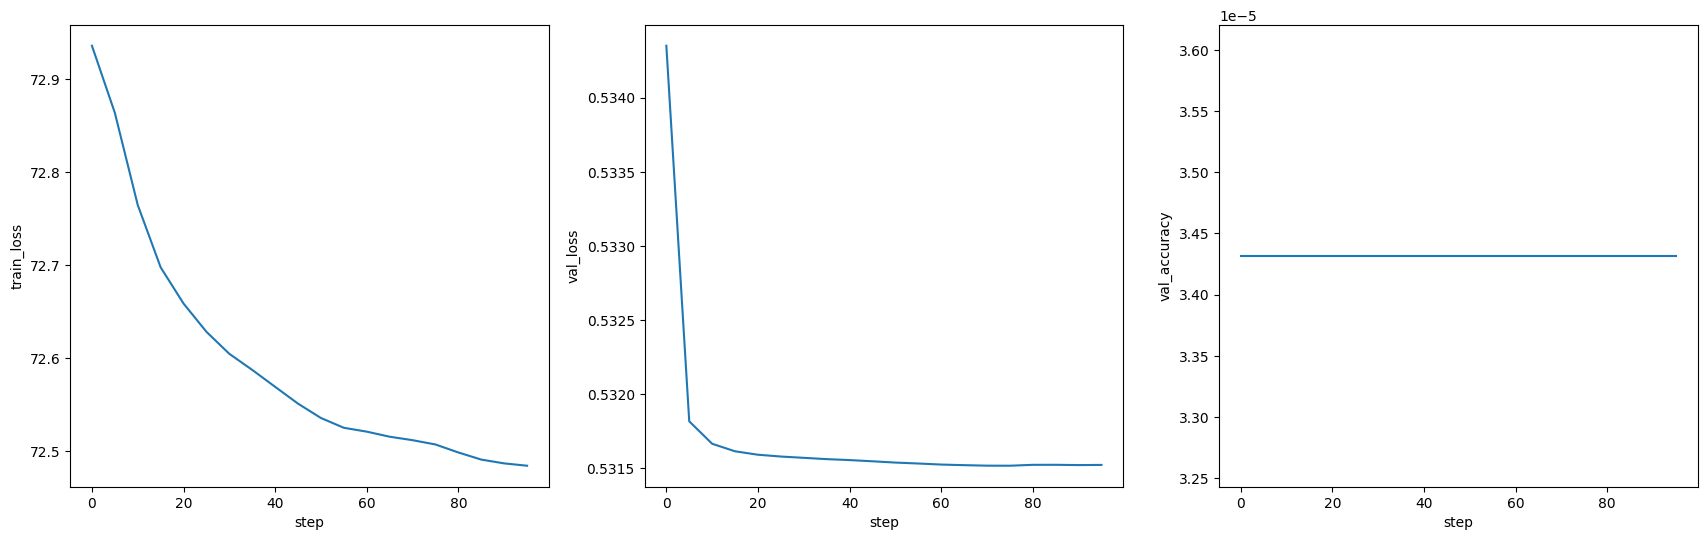

In [13]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1,3,1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1,3,2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1,3,3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')